###Make classification data and get it ready



In [ ]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

#Create Circle
X, y=make_circles(n_samples,noise=0.03,random_state=42)

In [ ]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
#Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

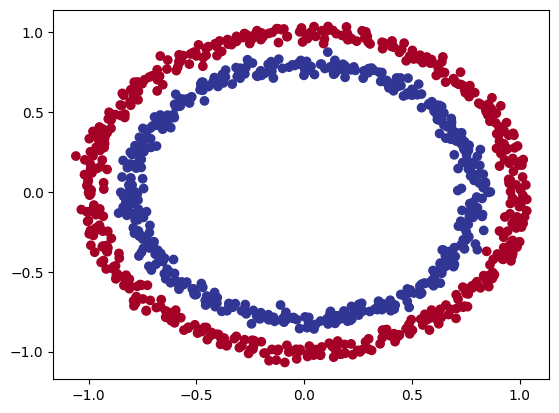

In [ ]:
#Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

Turn data into tensors and create train-test split

In [ ]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#View the first five samples
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

###Building a model

In [ ]:
#Stabdard PyTorch imports
import torch
from torch import nn

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

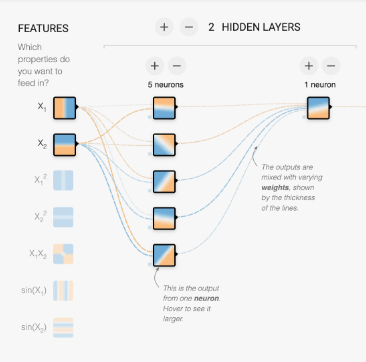

In [ ]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1555],
        [0.2162],
        [0.1384],
        [0.1598],
        [0.3639],
        [0.3993],
        [0.3915],
        [0.4349],
        [0.1289],
        [0.2228]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


###Setup loss function and optimizer

In [ ]:
#Create a loss function
#loss_fn = nn.BCELoss() #BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()

#Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [ ]:
#Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #torch.eq() calculates where two tensors are equal
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
#View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]

tensor([[0.1555],
        [0.2162],
        [0.1384],
        [0.1598],
        [0.3639]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
#Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5388],
        [0.5539],
        [0.5345],
        [0.5399],
        [0.5900]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

###Building a training and testing loop

In [ ]:
torch.manual_seed(42)

#Set number of epochs
epochs = 100

#Put data to target device
X_train,y_train =X_train.to(device),y_train.to(device)
X_test,y_test =X_test.to(device),y_test.to(device)

#Building training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  #1) Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2) Calculate loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  #3) Optimizer zero grad
  optimizer.zero_grad()

  #4) Loss backwards
  loss.backward()

  #5) Optimizer step
  optimizer.step()

  ###Testing
  model_0.eval()
  with torch.inference_mode():
    #1) Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2) Calculate loss/accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                        y_pred=test_pred)
  #Print out what's happening every 10 epochs
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69328, Accuracy: 49.50% | Test loss: 0.69370, Test acc: 51.00%
Epoch: 10 | Loss: 0.69325, Accuracy: 49.50% | Test loss: 0.69374, Test acc: 50.00%
Epoch: 20 | Loss: 0.69322, Accuracy: 49.50% | Test loss: 0.69378, Test acc: 51.00%
Epoch: 30 | Loss: 0.69319, Accuracy: 49.88% | Test loss: 0.69382, Test acc: 50.50%
Epoch: 40 | Loss: 0.69317, Accuracy: 49.62% | Test loss: 0.69386, Test acc: 50.00%
Epoch: 50 | Loss: 0.69315, Accuracy: 50.25% | Test loss: 0.69389, Test acc: 48.50%
Epoch: 60 | Loss: 0.69313, Accuracy: 50.50% | Test loss: 0.69393, Test acc: 50.00%
Epoch: 70 | Loss: 0.69311, Accuracy: 50.38% | Test loss: 0.69396, Test acc: 48.50%
Epoch: 80 | Loss: 0.69310, Accuracy: 50.38% | Test loss: 0.69400, Test acc: 49.00%
Epoch: 90 | Loss: 0.69308, Accuracy: 50.00% | Test loss: 0.69403, Test acc: 49.50%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

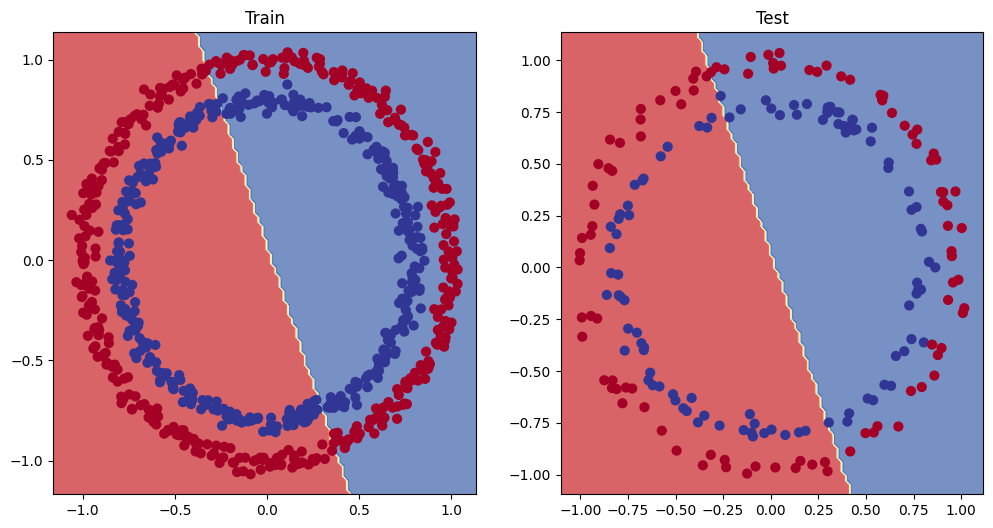

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

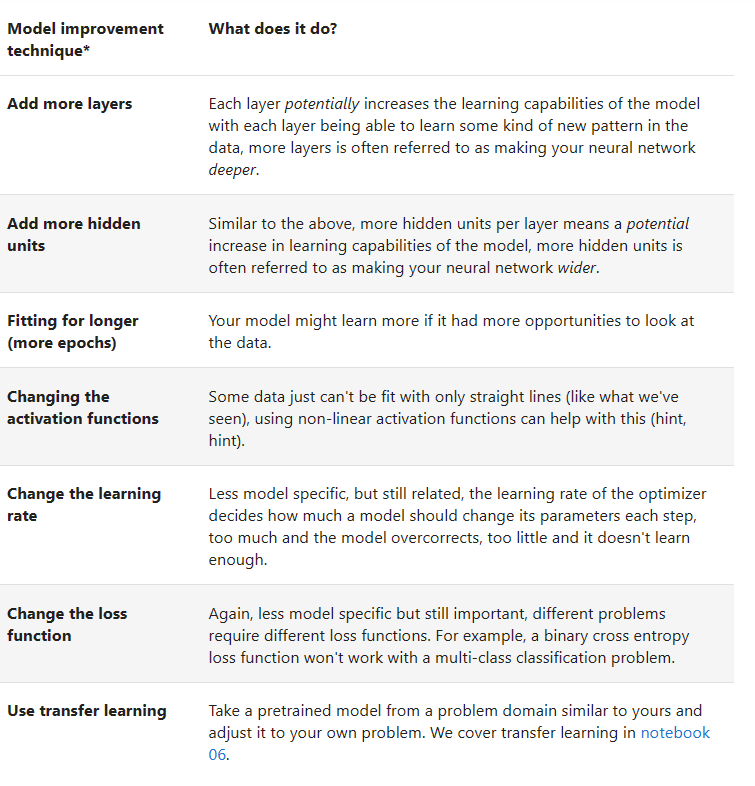

---Shaahid Ahmed N

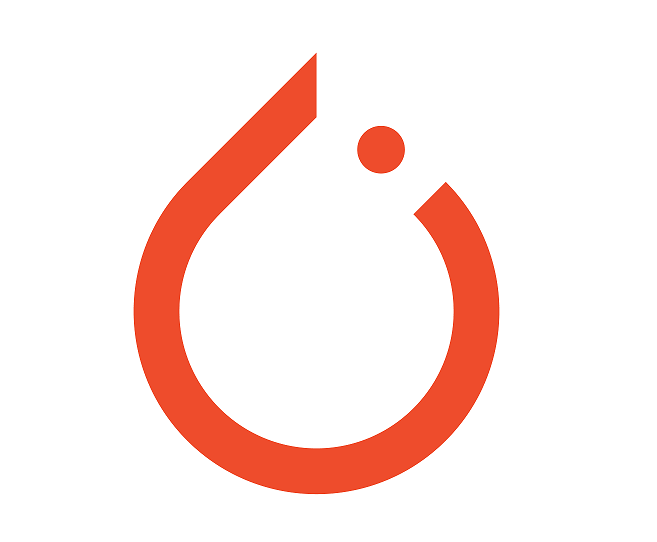